# Example
Designing a 12 hours ahead water inflow forecast using XGBOOST.

In [1]:
import pandas as pd
import seaborn as sns

from darts.models import XGBModel

from utils import (
    compute_errors,
    get_rmse,
    get_mape,
    example_target_and_features,
    example_train_subseries,
    example_test_series,
    visualize_example_measurements,
    generate_baseline_df,
    assemble_comparison,
)

Support for PyTorch based likelihood models not available. To enable them, install "darts", "u8darts[torch]" or "u8darts[all]" (with pip); or "u8darts-torch" or "u8darts-all" (with conda).
Support for Torch based models not available. To enable them, install "darts", "u8darts[torch]" or "u8darts[all]" (with pip); or "u8darts-torch" or "u8darts-all" (with conda).


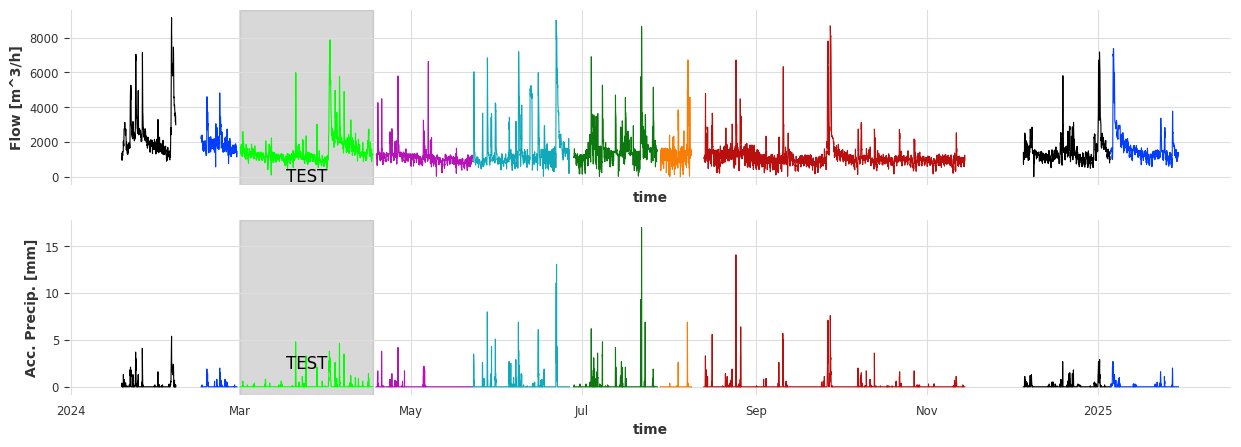

In [2]:
visualize_example_measurements()

## Modelling

In [3]:
target_var = "flow"
train_subseries = example_train_subseries()
train_target, train_features = example_target_and_features(train_subseries, target_var)

n_subseries = len(train_target)
feature_labels = list(train_features[0].components)
n_features = len(feature_labels)

print(f"Total number of train samples {sum([len(s) for s in train_subseries])}")

Total number of train samples 6961


In [4]:
output_chunk_length = 12
n_ar_lags = 6
n_past_lags = 6
n_future_lags = (6, output_chunk_length)
n_lags = max(n_ar_lags, n_past_lags, n_future_lags[1])

encoders = {
    "cyclic": {"future": "month"},
    "datetime_attribute": {"future": "hour"},
}

xgbmodel = XGBModel(
    lags=n_ar_lags,
    lags_past_covariates=n_past_lags,
    lags_future_covariates=n_future_lags,
    output_chunk_length=output_chunk_length,
    add_encoders=encoders,
)

We define the `Model` class to better access the model and its estimator (will be used during feature selection).

In [ ]:
def is_future(target: str) -> bool:
    # Function to identify future covariates
    future_tags = ["polyfeature_", "dow_"]
    return any(sub in target for sub in future_tags)


feature_names = train_features[0].components
all_past_components = [c for c in feature_names if not is_future(c)]
all_future_components = [c for c in feature_names if is_future(c)]
past_components = [fn for fn in feature_labels if fn in all_past_components]
future_components = [fn for fn in feature_labels if fn in all_future_components]

assert len(past_components) > 0
assert len(future_components) > 0

selected_past_covariates = [s[past_components] for s in train_features]
selected_future_covariates = [s[future_components] for s in train_features]


test_ts = example_test_series()
test_target, test_covariates = example_target_and_features(test_ts, target_var)
selected_past_covariates_test = test_covariates[past_components]
selected_future_covariates_test = test_covariates[future_components]

# The covariates ts has been cropped due to the smoothing of precipitation,
# so we need to crop the target to match the time index
min_ts_test = selected_past_covariates_test.time_index[0]
test_target.drop_before(min_ts_test)

In [6]:
xgbmodel.fit(
    train_target,
    future_covariates=selected_future_covariates,
    past_covariates=selected_past_covariates,
)

XGBModel(lags=6, lags_past_covariates=6, lags_future_covariates=(6, 12), output_chunk_length=12, output_chunk_shift=0, add_encoders={'cyclic': {'future': 'month'}, 'datetime_attribute': {'future': 'hour'}}, likelihood=None, quantiles=None, random_state=None, multi_models=True, use_static_covariates=True)

## Testing

- At every step of the test series, we forecast the next 12 hours and compare.

In [ ]:
candidate_errors = compute_errors(
    test_target,
    xgbmodel,
    output_chunk_length,
    past_covariates=selected_past_covariates_test,
    future_covariates=selected_future_covariates_test,
)

In [11]:
df_baseline = generate_baseline_df(test_target, n_ar_lags, output_chunk_length)
df_candidate = pd.DataFrame(
    {
        "RMSE": get_rmse(candidate_errors),
        "MAPE": get_mape(candidate_errors),
        "model": "xgb",
    }
)

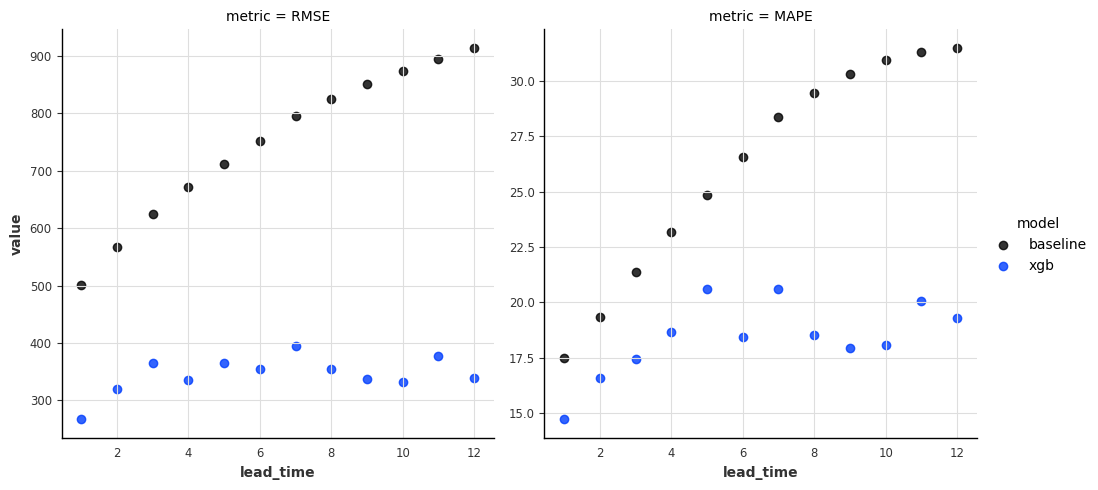

In [12]:
comparison = assemble_comparison([df_baseline, df_candidate])

sns.lmplot(
    data=comparison,
    x="lead_time",
    y="value",
    col="metric",
    hue="model",
    fit_reg=False,
    facet_kws=dict(sharey=False),
);